In [1]:
# Unet with ResNet 34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 450kB 35.6MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 3.9MB 50.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=a0f5c498557a4c181ef59f971367e669ce0fa7a6ffd4c5d47cd1abbd0e9aac80
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [2]:
!pip install segmentation-models

In [3]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath =  dataPath + '/Train'
testPath  =  dataPath + '/Test'
valPath   =  dataPath + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs = getData(trainPath, trainImgsFile)
trainLabels = getData(trainPath, trainLabelsFile)

#testImgs   = getData(testPath, testImgsFile)
#testLabels = getData(testPath, testLabelsFile)

valImgs    = getData(valPath, valImgsFile)
valLabels  = getData(valPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)

Got train and validation data
(1000, 480, 320, 1) (251, 480, 320, 1)
(1000, 480, 320, 1) (251, 480, 320, 1)


In [ ]:
# Create the model (without pre-trained ImageNet weights)
# BATCH_SIZE = 16
# EPOCHS     = 20 (use early stopping as well to avoid overfitting (and store the epochs till then))
import os
import numpy as np
import segmentation_models as sm

# create the model
model = sm.Unet('resnet18', input_shape=(480, 320, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [4]:
# Compile the model with loss function, optimizer and metric
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    'Adam',
    loss='sparse_categorical_crossentropy',
    metrics=[sm.metrics.iou_score],
)

In [5]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [6]:
# Start training the model

# change the label type to float32
# tf.cast(trainLabels, tf.float32)
# tf.cast(trainImgs, tf.float32)
# tf.cast(valLabels, tf.float32)
# tf.cast(valImgs, tf.float32)

history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 52s 52ms/sample - loss: 0.6787 - iou_score: 0.0694 - val_loss: 0.6104 - val_iou_score: 0.0259
Epoch 2/30
1000/1000 [==============================] - 34s 34ms/sample - loss: 0.1317 - iou_score: 0.0730 - val_loss: 8.7490 - val_iou_score: 0.0318
Epoch 3/30
1000/1000 [==============================] - 34s 34ms/sample - loss: 0.0992 - iou_score: 0.0879 - val_loss: 0.4213 - val_iou_score: 0.0285
Epoch 4/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.0821 - iou_score: 0.0915 - val_loss: 0.1221 - val_iou_score: 0.0940
Epoch 5/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.0661 - iou_score: 0.1020 - val_loss: 0.0760 - val_iou_score: 0.1010
Epoch 6/30
1000/1000 [==============================] - 35s 35ms/sample - loss: 0.0620 - iou_score: 0.1032 - val_loss: 0.0777 - val_iou_score: 0.0885
Epoch 7/30
1000/1000 [==============================]

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])


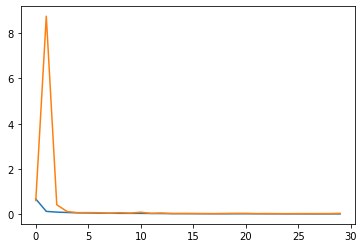

In [8]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

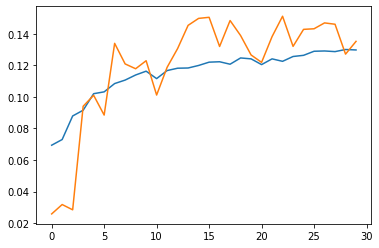

In [9]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])

In [11]:
# get the testdata
testImgs   = getData(testPath, testImgsFile)
testLabels = getData(testPath, testLabelsFile)

In [12]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 11s 17ms/sample - loss: 0.0401 - iou_score: 0.1302


[0.04006873346514988, 0.13021104]

In [13]:
# save the model weights
weightFileName = "UResNet18_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/UNET'
model.save_weights(weightPath + "/" + weightFileName)


In [14]:
model.load_weights(weightPath + "/" + weightFileName)
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 6s 10ms/sample - loss: 0.0401 - iou_score: 0.1302


[0.04006873346514988, 0.13021104]

In [17]:
modelFileName = "UResNet18_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/Unet'
model.save(modelPath + "/" + modelFileName)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Underwater_Segmentation_Research/Models/Unet/UResNet18_30e_16b/assets


In [16]:
# Check the GPU configuration
!nvidia-smi

Mon Mar 29 22:41:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   8802MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# check the outputs here
outputs = model.predict(testImgs)

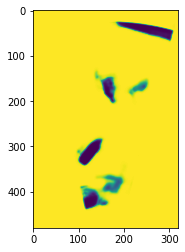

In [19]:
img = outputs[0,:,:,0]
plt.imshow(img)
plt.show()